In [ ]:
!pip install pydicom Pillow


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


#Functions

In [ ]:
import os
import pydicom
from PIL import Image
import numpy as np

def has_pixel_data(ds):
    return hasattr(ds, 'PixelData')

def dicom_to_jpeg(input_dir, output_dir):
    for root, dirs, files in os.walk(input_dir):
        for file in files:
            if file.lower().endswith(".dcm"):
                dicom_path = os.path.join(root, file)
                try:
                    ds = pydicom.dcmread(dicom_path)

                    # Skip if no pixel data
                    if not has_pixel_data(ds):
                        print(f"Skipped (no pixel data): {dicom_path}")
                        continue

                    img_array = ds.pixel_array

                    # Normalize to 0-255
                    img_array = (img_array - np.min(img_array)) / (np.max(img_array) - np.min(img_array)) * 255
                    img_array = img_array.astype(np.uint8)

                    # Convert to grayscale image
                    img = Image.fromarray(img_array).convert("L")

                    # Prepare output path
                    relative_path = os.path.relpath(root, input_dir)
                    output_folder = os.path.join(output_dir, relative_path)
                    os.makedirs(output_folder, exist_ok=True)
                    jpeg_path = os.path.join(output_folder, file.replace(".dcm", ".jpeg"))
                    img.save(jpeg_path)

                except Exception as e:
                    print(f"Failed to convert {dicom_path}: {e}")

# Run the function
input_folder = "P2"
output_folder = "P2_jpeg"
dicom_to_jpeg(input_folder, output_folder)


Skipped (no pixel data): P2\D1\RS.1.2.246.352.205.5379284079904360119.14291834989016522648.dcm
Skipped (no pixel data): P2\D15\RS.1.2.246.352.205.5674467686128013812.8717811939491971728.dcm
Skipped (no pixel data): P2\D18\RS.1.2.246.352.205.5156421329384799693.4369044680362654861.dcm
Skipped (no pixel data): P2\D22\RS.1.2.246.352.205.5159931533447357413.9442159017739604395.dcm
Skipped (no pixel data): P2\D29\RS.1.2.246.352.205.4620304098515285022.16661046463845297284.dcm


In [ ]:
import os
import pydicom
import numpy as np
import cv2
from PIL import Image

def load_dicom_images(folder):
    dicoms = []
    for filename in os.listdir(folder):
        if filename.endswith(".dcm") and not filename.startswith("RS"):
            ds = pydicom.dcmread(os.path.join(folder, filename))
            if hasattr(ds, 'PixelData'):
                dicoms.append(ds)
    # Sort by ImagePositionPatient to maintain slice order
    dicoms.sort(key=lambda x: float(x.ImagePositionPatient[2]))
    return dicoms

def load_rs_file(folder):
    for f in os.listdir(folder):
        if f.startswith("RS") and f.endswith(".dcm"):
            return pydicom.dcmread(os.path.join(folder, f))
    return None

def get_contours(rs, image_slices):
    contours_by_slice = {}
    if "StructureSetROISequence" not in rs or "ROIContourSequence" not in rs:
        return contours_by_slice

    # Map SOPInstanceUID to image index
    sop_to_index = {s.SOPInstanceUID: i for i, s in enumerate(image_slices)}

    for roi in rs.ROIContourSequence:
        for contour in roi.ContourSequence:
            sop = contour.ContourImageSequence[0].ReferencedSOPInstanceUID
            if sop not in sop_to_index:
                continue
            slice_idx = sop_to_index[sop]
            points = np.array(contour.ContourData).reshape(-1, 3)
            pixel_coords = []

            # Transform world coordinates to pixel coordinates
            img = image_slices[slice_idx]
            origin = np.array(img.ImagePositionPatient)
            spacing = np.array(list(img.PixelSpacing) + [img.SliceThickness])
            orientation = np.array(img.ImageOrientationPatient).reshape(2, 3)
            orientation = np.vstack([orientation, np.cross(*orientation)])

            for pt in points:
                relative = np.array(pt) - origin
                pixel = np.linalg.inv(orientation.T) @ relative
                x, y = int(round(pixel[0] / spacing[0])), int(round(pixel[1] / spacing[1]))
                pixel_coords.append((x, y))

            contours_by_slice.setdefault(slice_idx, []).append(np.array(pixel_coords, dtype=np.int32))
    return contours_by_slice

def save_with_contours(folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    slices = load_dicom_images(folder)
    rs = load_rs_file(folder)
    contours = get_contours(rs, slices)

    for i, ds in enumerate(slices):
        img = ds.pixel_array.astype(np.float32)
        img = (img - img.min()) / (img.max() - img.min()) * 255
        img = img.astype(np.uint8)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

        if i in contours:
            for contour in contours[i]:
                cv2.polylines(img_rgb, [contour], isClosed=True, color=(0, 255, 0), thickness=2)

        out_path = os.path.join(output_folder, f"slice_{i:03d}.jpeg")
        Image.fromarray(img_rgb).save(out_path)

# Run for one folder (e.g., D1)
save_with_contours("P2/D1", "P2_jpeg_contours/D1")


In [ ]:
import os
import pydicom
import numpy as np
import cv2
from PIL import Image

def load_dicom_images(folder):
    slices = []
    for filename in os.listdir(folder):
        if filename.endswith(".dcm"):
            path = os.path.join(folder, filename)
            try:
                ds = pydicom.dcmread(path)
                if 'PixelData' in ds:
                    slices.append(ds)
            except Exception as e:
                print(f"Failed to read {path}: {e}")
    slices.sort(key=lambda x: float(x.ImagePositionPatient[2]))
    return slices

def load_rs_file(folder):
    for filename in os.listdir(folder):
        if filename.endswith(".dcm"):
            path = os.path.join(folder, filename)
            ds = pydicom.dcmread(path)
            if ds.Modality == "RTSTRUCT":
                return ds
    return None

def get_contours(rs, image_slices, target_roi_name="SpinalCanal"):
    structure_set_roi_sequence = rs.StructureSetROISequence
    roi_name_to_number = {roi.ROIName: roi.ROINumber for roi in structure_set_roi_sequence}

    if target_roi_name not in roi_name_to_number:
        print(f"ROI '{target_roi_name}' not found.")
        return []

    roi_number = roi_name_to_number[target_roi_name]

    contours = []
    for item in rs.ROIContourSequence:
        if item.ReferencedROINumber != roi_number:
            continue
        for contour_seq in item.ContourSequence:
            points = np.array(contour_seq.ContourData).reshape(-1, 3)

            z_pos = points[0][2]
            slice_idx = None
            for i, s in enumerate(image_slices):
                if abs(s.ImagePositionPatient[2] - z_pos) < 1e-2:
                    slice_idx = i
                    break

            if slice_idx is None:
                continue

            img = image_slices[slice_idx]
            origin = np.array(img.ImagePositionPatient)
            spacing = np.array(list(img.PixelSpacing) + [float(img.SliceThickness)])
            orientation = np.array(img.ImageOrientationPatient).reshape(2, 3)
            orientation = np.vstack([orientation, np.cross(*orientation)])
            transform = orientation.T * spacing

            # Convert 3D contour coordinates to 2D image pixel coordinates
            pixel_coords = np.linalg.inv(transform) @ (points.T - origin.reshape(3, 1))
            pixel_coords = pixel_coords[:2].T
            pixel_coords = np.round(pixel_coords).astype(np.int32)

            contours.append((slice_idx, pixel_coords))

    return contours

def save_with_contours(folder, output_folder, target_roi_name="SpinalCanal"):
    os.makedirs(output_folder, exist_ok=True)

    slices = load_dicom_images(folder)
    rs = load_rs_file(folder)
    if rs is None:
        print("No RTSTRUCT file found.")
        return

    contours = get_contours(rs, slices, target_roi_name)

    # Group contours by slice
    contours_by_slice = {}
    for slice_idx, contour in contours:
        contours_by_slice.setdefault(slice_idx, []).append(contour)

    for i, ds in enumerate(slices):
        img = ds.pixel_array.astype(np.float32)
        img -= img.min()
        img /= img.max()
        img *= 255
        img = img.astype(np.uint8)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

        if i in contours_by_slice:
            for contour in contours_by_slice[i]:
                cv2.drawContours(img_rgb, [contour], -1, (0, 255, 0), 2)

        out_path = os.path.join(output_folder, f"slice_{i:03}.jpeg")
        Image.fromarray(img_rgb).save(out_path)

    print(f"Saved contours for '{target_roi_name}' in: {output_folder}")

# Run it on a folder (example: D1)
save_with_contours("P2/D1", "P2_jpeg_contours/D1", target_roi_name="SpinalCord")


Saved contours for 'SpinalCord' in: P2_jpeg_contours/D1


#Segmentation Model

Saved 123 images and masks.
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/20
25/25 [==============================] - 10s 276ms/step - loss: 0.1891 - accuracy: 0.9728 - dice_coef: 0.0162 - iou_coef: 0.0162 - val_loss: 0.0068 - val_accuracy: 0.9997 - val_dice_coef: 0.0046 - val_iou_coef: 0.0046
Epoch 2/20
25/25 [==============================] - 6s 251ms/step - loss: 0.0035 - accuracy: 0.9997 - dice_coef: 0.0251 - iou_coef: 0.0250 - val_loss: 0.0017 - val_accuracy: 0.9997 - val_dice_coef: 0.0541 - val_iou_coef: 0.0533
Epoch 3/20
25/25 [==============================] - 6s 245ms/step - loss: 0.0016 - accuracy: 0.9997 - dice_coef: 0.0437 - iou_coef: 0.0422 - val_loss: 0.0015 - val_accuracy: 0.9997 - val_dice_coef: 0.0383 - val_iou_coef: 0.0365
Epoch 4/20
25/25 [==============================] - 6s 245ms/step - loss: 0.0014 - accuracy: 0.9997 - dice_coef: 0.0452 - iou_coef: 0.0436

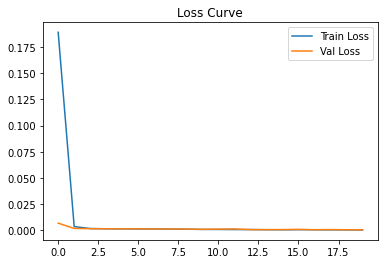

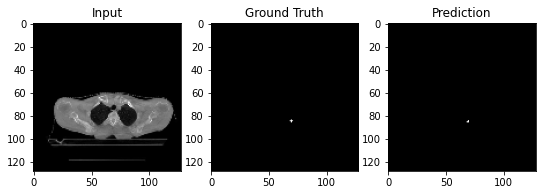

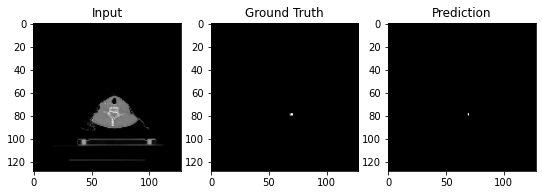

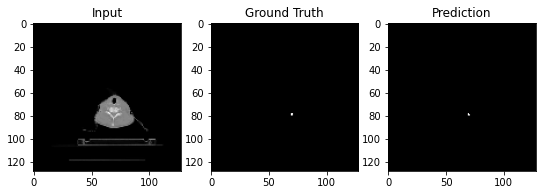

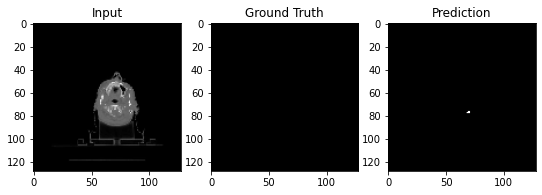

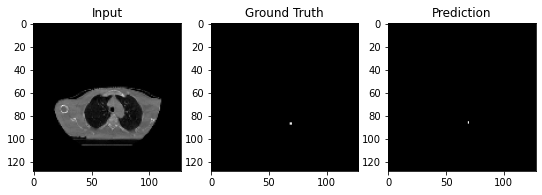

In [ ]:
import os
import pydicom
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import plot_model

# --------------------
# STEP 1: Load DICOM Slices
# --------------------
def load_dicom_images(folder):
    slices = []
    for filename in os.listdir(folder):
        if filename.endswith(".dcm"):
            path = os.path.join(folder, filename)
            try:
                ds = pydicom.dcmread(path)
                if 'PixelData' in ds:
                    slices.append(ds)
            except Exception as e:
                print(f"Failed to read {path}: {e}")
    slices.sort(key=lambda x: float(x.ImagePositionPatient[2]))
    return slices

# --------------------
# STEP 2: Load RTSTRUCT file
# --------------------
def load_rs_file(folder):
    for filename in os.listdir(folder):
        if filename.endswith(".dcm"):
            path = os.path.join(folder, filename)
            ds = pydicom.dcmread(path)
            if ds.Modality == "RTSTRUCT":
                return ds
    return None

# --------------------
# STEP 3: Get Contours
# --------------------
def get_contours(rs, image_slices, target_roi_name="SpinalCord"):
    structure_set_roi_sequence = rs.StructureSetROISequence
    roi_name_to_number = {roi.ROIName: roi.ROINumber for roi in structure_set_roi_sequence}

    if target_roi_name not in roi_name_to_number:
        print(f"ROI '{target_roi_name}' not found.")
        return []

    roi_number = roi_name_to_number[target_roi_name]
    contours = []

    for item in rs.ROIContourSequence:
        if item.ReferencedROINumber != roi_number:
            continue
        for contour_seq in item.ContourSequence:
            points = np.array(contour_seq.ContourData).reshape(-1, 3)
            z_pos = points[0][2]
            slice_idx = None
            for i, s in enumerate(image_slices):
                if abs(s.ImagePositionPatient[2] - z_pos) < 1e-2:
                    slice_idx = i
                    break
            if slice_idx is None:
                continue

            img = image_slices[slice_idx]
            origin = np.array(img.ImagePositionPatient)
            spacing = np.array(list(img.PixelSpacing) + [float(img.SliceThickness)])
            orientation = np.array(img.ImageOrientationPatient).reshape(2, 3)
            orientation = np.vstack([orientation, np.cross(*orientation)])
            transform = orientation.T * spacing

            pixel_coords = np.linalg.inv(transform) @ (points.T - origin.reshape(3, 1))
            pixel_coords = pixel_coords[:2].T
            pixel_coords = np.round(pixel_coords).astype(np.int32)

            contours.append((slice_idx, pixel_coords))

    return contours

# --------------------
# STEP 4: Save Images & Masks
# --------------------
def save_images_and_masks(folder, output_folder_img, output_folder_mask, target_roi_name="SpinalCord"):
    os.makedirs(output_folder_img, exist_ok=True)
    os.makedirs(output_folder_mask, exist_ok=True)

    slices = load_dicom_images(folder)
    rs = load_rs_file(folder)
    if rs is None:
        print("No RTSTRUCT file found.")
        return

    contours = get_contours(rs, slices, target_roi_name)

    contours_by_slice = {}
    for slice_idx, contour in contours:
        contours_by_slice.setdefault(slice_idx, []).append(contour)

    for i, ds in enumerate(slices):
        img = ds.pixel_array.astype(np.float32)
        img -= img.min()
        img /= img.max()
        img *= 255
        img = img.astype(np.uint8)

        Image.fromarray(img).save(os.path.join(output_folder_img, f"slice_{i:03}.jpeg"))

        # Create mask
        mask = np.zeros_like(img, dtype=np.uint8)
        if i in contours_by_slice:
            for contour in contours_by_slice[i]:
                cv2.drawContours(mask, [contour], -1, 255, -1)
        Image.fromarray(mask).save(os.path.join(output_folder_mask, f"slice_{i:03}.png"))

    print(f"Saved {len(slices)} images and masks.")

# --------------------
# STEP 5: Prepare Data for Training
# --------------------
def load_dataset(img_folder, mask_folder, img_size=(128, 128)):
    images, masks = [], []
    for filename in sorted(os.listdir(img_folder)):
        img_path = os.path.join(img_folder, filename)
        mask_path = os.path.join(mask_folder, filename.replace(".jpeg", ".png"))

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        img = cv2.resize(img, img_size)
        mask = cv2.resize(mask, img_size)

        images.append(img)
        masks.append(mask)

    images = np.expand_dims(np.array(images) / 255.0, axis=-1)
    masks = np.expand_dims(np.array(masks) / 255.0, axis=-1)
    return images, masks

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection + smooth)


# --------------------
# STEP 6: Build U-Net Model
# --------------------
def unet_model(input_shape):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c4)

    # Decoder
    u5 = layers.UpSampling2D((2, 2))(c4)
    u5 = layers.concatenate([u5, c3])
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    u6 = layers.UpSampling2D((2, 2))(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.UpSampling2D((2, 2))(c6)
    u7 = layers.concatenate([u7, c1])
    c7 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c7)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c7)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', dice_coef, iou_coef])
    return model

# --------------------
# STEP 7: Main Execution
# --------------------
if __name__ == "__main__":
    # Paths
    dicom_folder = "P2/D1"
    img_out = "dataset/images"
    mask_out = "dataset/masks"

    # Create images and masks
    save_images_and_masks(dicom_folder, img_out, mask_out, target_roi_name="SpinalCord")

    # Load dataset
    X, Y = load_dataset(img_out, mask_out)
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

    # Model
    model = unet_model((128, 128, 1))
    plot_model(model, to_file="unet_model.png", show_shapes=True)

    # Train
    history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=20, batch_size=4)

    # Plot Training History
    plt.figure()
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title("Loss Curve")
    plt.savefig("loss_curve.png")

    # Predictions
    preds = model.predict(X_val[:5])
    for i in range(5):
        plt.figure(figsize=(9, 3))
        plt.subplot(1, 3, 1)
        plt.imshow(X_val[i].squeeze(), cmap='gray')
        plt.title("Input")
        plt.subplot(1, 3, 2)
        plt.imshow(Y_val[i].squeeze(), cmap='gray')
        plt.title("Ground Truth")
        plt.subplot(1, 3, 3)
        plt.imshow(preds[i].squeeze() > 0.5, cmap='gray')
        plt.title("Prediction")
        plt.savefig(f"prediction_{i}.png")


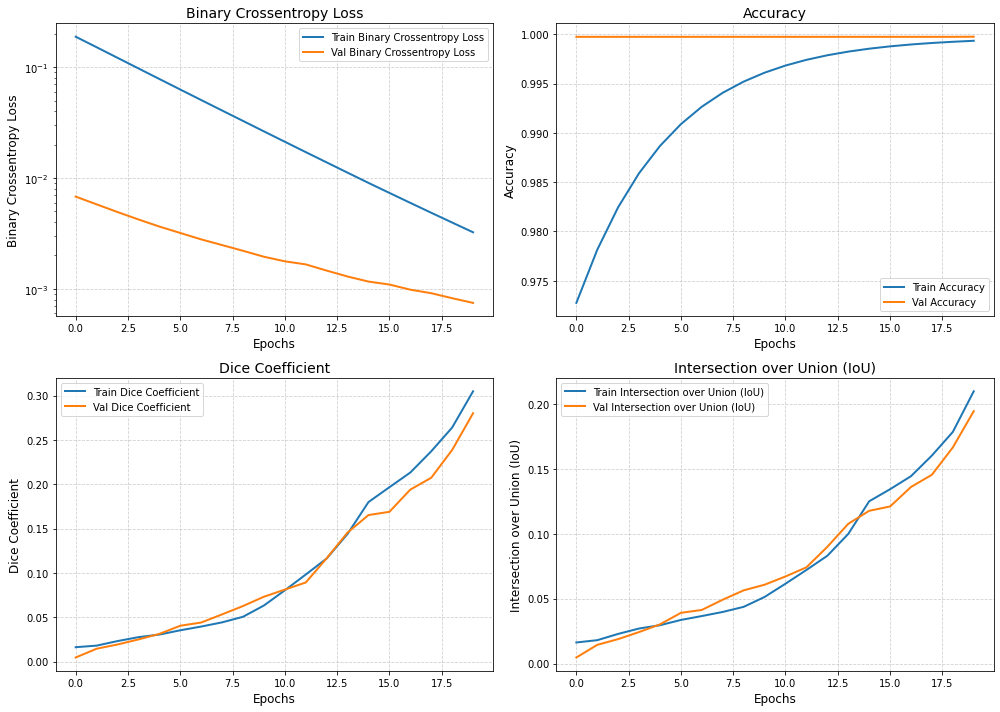

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def smooth_curve(points, factor=0.8):
    smoothed = []
    for p in points:
        if smoothed:
            smoothed.append(smoothed[-1] * factor + p * (1 - factor))
        else:
            smoothed.append(p)
    return smoothed

def plot_all_metrics(history, output_path="training_metrics_full.png"):
    metrics = ['loss', 'accuracy', 'dice_coef', 'iou_coef']
    metric_names = {
        'loss': 'Binary Crossentropy Loss',
        'accuracy': 'Accuracy',
        'dice_coef': 'Dice Coefficient',
        'iou_coef': 'Intersection over Union (IoU)'
    }

    plt.figure(figsize=(14, 10))

    for idx, metric in enumerate(metrics, 1):
        plt.subplot(2, 2, idx)
        train_values = smooth_curve(history.history[metric])
        val_values = smooth_curve(history.history[f'val_{metric}'])

        plt.plot(train_values, label=f'Train {metric_names[metric]}', linewidth=2)
        plt.plot(val_values, label=f'Val {metric_names[metric]}', linewidth=2)

        if metric == 'loss':
            plt.yscale('log')  # log scale for loss
        plt.title(metric_names[metric], fontsize=14)
        plt.xlabel('Epochs', fontsize=12)
        plt.ylabel(metric_names[metric], fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend(fontsize=10)

    plt.tight_layout()
    plt.savefig(output_path, dpi=300)
    plt.show()

# Usage after training:
plot_all_metrics(history, "all_training_metrics.png")


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

def save_prediction_examples_with_contour(model, X_val, Y_val, save_dir="predictions", num_samples=5, threshold=0.5):
    os.makedirs(save_dir, exist_ok=True)
    preds = model.predict(X_val[:num_samples])

    for i in range(num_samples):
        pred_mask = (preds[i].squeeze() > threshold).astype(np.uint8)
        true_mask = Y_val[i].squeeze().astype(np.uint8)
        input_img = (X_val[i].squeeze() * 255).astype(np.uint8)

        # Create overlay with contour
        overlay_img = cv2.cvtColor(input_img, cv2.COLOR_GRAY2BGR)
        contours, _ = cv2.findContours(pred_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(overlay_img, contours, -1, (255, 0, 0), 2)  # Red contour for prediction

        # Plotting
        plt.figure(figsize=(12, 3))

        # Input
        plt.subplot(1, 4, 1)
        plt.imshow(input_img, cmap='gray')
        plt.title("Input", fontsize=12)
        plt.axis('off')

        # Ground Truth
        plt.subplot(1, 4, 2)
        plt.imshow(true_mask, cmap='gray')
        plt.title("Ground Truth", fontsize=12)
        plt.axis('off')

        # Prediction
        plt.subplot(1, 4, 3)
        plt.imshow(pred_mask, cmap='gray')
        plt.title("Prediction", fontsize=12)
        plt.axis('off')

        # Overlay
        plt.subplot(1, 4, 4)
        plt.imshow(overlay_img)
        plt.title("Prediction Contour", fontsize=12)
        plt.axis('off')

        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f"sample_{i}.png"), dpi=300)
        plt.close()

# Usage after training
save_prediction_examples_with_contour(model, X_val, Y_val, save_dir="predicted_with_contour", num_samples=10)


1/1 [==============================] - 0s 163ms/step


In [ ]:
plot_model(
        model,
        to_file="model_architecture.png",
        show_shapes=True,
        show_dtype=True,
        show_layer_names=True,
        rankdir="TB",  # top-bottom
        expand_nested=True
    )
print("✅ Model architecture diagram saved as model_architecture.png")

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
✅ Model architecture diagram saved as model_architecture.png


In [ ]:
!pip install graphviz


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import os

selected_patients = ["P1", "P2", "P3"]
output_root = "Contour_JPEGs"
target_roi_name = "SpinalCord"  # Change this as needed

for patient_id in selected_patients:
    patient_path = patient_id
    for session_folder in os.listdir(patient_path):
        session_path = os.path.join(patient_path, session_folder)
        if os.path.isdir(session_path):
            output_path = os.path.join(output_root, patient_id, session_folder)
            print(f"\nProcessing {patient_id}/{session_folder}...")
            try:
                save_with_contours(session_path, output_path, target_roi_name)
            except Exception as e:
                print(f"Failed for {patient_id}/{session_folder}: {e}")



Processing P1/D22...
Saved contours for 'SpinalCord' in: Contour_JPEGs\P1\D22

Processing P2/D1...
Saved contours for 'SpinalCord' in: Contour_JPEGs\P2\D1

Processing P2/D15...
Saved contours for 'SpinalCord' in: Contour_JPEGs\P2\D15

Processing P2/D18...
Saved contours for 'SpinalCord' in: Contour_JPEGs\P2\D18

Processing P2/D22...
Saved contours for 'SpinalCord' in: Contour_JPEGs\P2\D22

Processing P2/D29...
Saved contours for 'SpinalCord' in: Contour_JPEGs\P2\D29

Processing P3/CT...
ROI 'SpinalCord' not found.
Saved contours for 'SpinalCord' in: Contour_JPEGs\P3\CT

Processing P3/D1...
Saved contours for 'SpinalCord' in: Contour_JPEGs\P3\D1

Processing P3/D25...
Saved contours for 'SpinalCord' in: Contour_JPEGs\P3\D25

Processing P3/D8...
Saved contours for 'SpinalCord' in: Contour_JPEGs\P3\D8


In [ ]:
import os
import shutil

input_root = "Contour_JPEGs/P2"
output_folder = "train_p2_v1"
slice_range = range(40, 61)  # inclusive: 40 to 60

os.makedirs(output_folder, exist_ok=True)

for session in os.listdir(input_root):
    session_path = os.path.join(input_root, session)
    if os.path.isdir(session_path):
        for slice_num in slice_range:
            slice_name = f"slice_{slice_num:03}.jpeg"
            src = os.path.join(session_path, slice_name)
            if os.path.exists(src):
                new_name = f"{session}_{slice_name}"  # Avoid filename clash
                dst = os.path.join(output_folder, new_name)
                shutil.copy(src, dst)
                print(f"Copied: {src} → {dst}")
            else:
                print(f"Missing: {src}")


Copied: Contour_JPEGs/P2\D1\slice_040.jpeg → train_p2_v1\D1_slice_040.jpeg
Copied: Contour_JPEGs/P2\D1\slice_041.jpeg → train_p2_v1\D1_slice_041.jpeg
Copied: Contour_JPEGs/P2\D1\slice_042.jpeg → train_p2_v1\D1_slice_042.jpeg
Copied: Contour_JPEGs/P2\D1\slice_043.jpeg → train_p2_v1\D1_slice_043.jpeg
Copied: Contour_JPEGs/P2\D1\slice_044.jpeg → train_p2_v1\D1_slice_044.jpeg
Copied: Contour_JPEGs/P2\D1\slice_045.jpeg → train_p2_v1\D1_slice_045.jpeg
Copied: Contour_JPEGs/P2\D1\slice_046.jpeg → train_p2_v1\D1_slice_046.jpeg
Copied: Contour_JPEGs/P2\D1\slice_047.jpeg → train_p2_v1\D1_slice_047.jpeg
Copied: Contour_JPEGs/P2\D1\slice_048.jpeg → train_p2_v1\D1_slice_048.jpeg
Copied: Contour_JPEGs/P2\D1\slice_049.jpeg → train_p2_v1\D1_slice_049.jpeg
Copied: Contour_JPEGs/P2\D1\slice_050.jpeg → train_p2_v1\D1_slice_050.jpeg
Copied: Contour_JPEGs/P2\D1\slice_051.jpeg → train_p2_v1\D1_slice_051.jpeg
Copied: Contour_JPEGs/P2\D1\slice_052.jpeg → train_p2_v1\D1_slice_052.jpeg
Copied: Contour_JPEGs/P2\

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import random

# Config
slice_range = range(40, 61)
base_path = "train_p2"
days = sorted(set(f.split("_")[0] for f in os.listdir(base_path)))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom Dataset
class ContourShiftDataset(Dataset):
    def __init__(self, base_path, slice_range, transform=None):
        self.base_path = base_path
        self.slice_range = slice_range
        self.transform = transform
        self.data = []
        self.prepare_pairs()

    def prepare_pairs(self):
        files = os.listdir(self.base_path)
        by_slice = {i: [] for i in self.slice_range}
        for f in files:
            for sl in self.slice_range:
                if f"_slice_{sl:03d}.jpeg" in f:
                    by_slice[sl].append(f)

        for sl in self.slice_range:
            imgs = by_slice[sl]
            for i in range(len(imgs)):
                for j in range(i + 1, len(imgs)):
                    img1 = imgs[i]
                    img2 = imgs[j]
                    # pseudo label: 0 if same day, 1 if different
                    label = 1 if img1.split("_")[0] != img2.split("_")[0] else 0
                    self.data.append((img1, img2, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img1_name, img2_name, label = self.data[idx]
        img1 = Image.open(os.path.join(self.base_path, img1_name)).convert('L')
        img2 = Image.open(os.path.join(self.base_path, img2_name)).convert('L')

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, torch.tensor(label, dtype=torch.float)

# Siamese Network
class SiameseNet(nn.Module):
    def __init__(self):
        super(SiameseNet, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.Linear(64 * 29 * 29 * 2, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 1)
        )

    def forward(self, x1, x2):
        f1 = self.cnn(x1).view(x1.size(0), -1)
        f2 = self.cnn(x2).view(x2.size(0), -1)
        out = torch.cat([f1, f2], dim=1)
        return self.fc(out)

# Training setup
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

dataset = ContourShiftDataset(base_path, slice_range, transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

model = SiameseNet().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training loop
for epoch in range(10):
    model.train()
    total_loss = 0
    for img1, img2, label in dataloader:
        img1, img2, label = img1.to(device), img2.to(device), label.to(device).unsqueeze(1)
        optimizer.zero_grad()
        output = model(img1, img2)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(dataloader):.4f}")


Epoch 1, Loss: 0.0976
Epoch 2, Loss: 0.0000
Epoch 3, Loss: 0.0000
Epoch 4, Loss: 0.0000
Epoch 5, Loss: 0.0000
Epoch 6, Loss: 0.0000
Epoch 7, Loss: 0.0000
Epoch 8, Loss: 0.0000
Epoch 9, Loss: 0.0000
Epoch 10, Loss: 0.0000


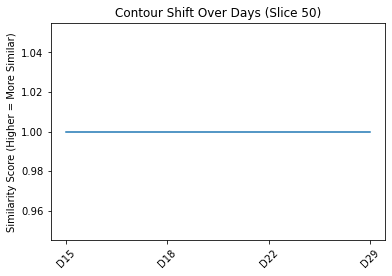

In [ ]:
import matplotlib.pyplot as plt

model.eval()
slice_id = 50  # Choose a slice
base_day = "D1"
ref_img = transform(Image.open(f"train_p2/{base_day}_slice_{slice_id:03d}.jpeg").convert('L')).unsqueeze(0).to(device)

scores = []
day_labels = []

for day in days:
    if day == base_day:
        continue
    path = f"train_p2/{day}_slice_{slice_id:03d}.jpeg"
    if not os.path.exists(path):
        continue
    cmp_img = transform(Image.open(path).convert('L')).unsqueeze(0).to(device)
    with torch.no_grad():
        score = torch.sigmoid(model(ref_img, cmp_img)).item()
    scores.append(score)
    day_labels.append(day)

plt.plot(day_labels, scores)
plt.ylabel("Similarity Score (Higher = More Similar)")
plt.title(f"Contour Shift Over Days (Slice {slice_id})")
plt.xticks(rotation=45)
plt.show()


In [ ]:
print(f"Label: {label[0].item()}, Pred: {pred[0].item():.4f}")


Label: 1.0, Pred: 1.0000


Epoch 1, Loss: 0.0823
Epoch 2, Loss: 0.0000
Epoch 3, Loss: 0.0000
Epoch 4, Loss: 0.0000
Epoch 5, Loss: 0.0000
Epoch 6, Loss: 0.0000
Epoch 7, Loss: 0.0000
Epoch 8, Loss: 0.0000
Epoch 9, Loss: 0.0000
Epoch 10, Loss: 0.0000


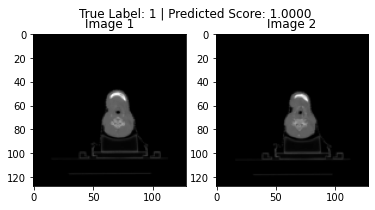

In [ ]:
import os
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt

# Config
slice_range = range(40, 61)
base_path = "train_p2"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom Dataset
class ContourShiftDataset(Dataset):
    def __init__(self, base_path, slice_range, transform=None):
        self.base_path = base_path
        self.slice_range = slice_range
        self.transform = transform
        self.data = []
        self.prepare_pairs()

    def prepare_pairs(self):
        files = os.listdir(self.base_path)
        by_slice = {i: [] for i in self.slice_range}
        for f in files:
            for sl in self.slice_range:
                if f"_slice_{sl:03d}.jpeg" in f:
                    by_slice[sl].append(f)

        for sl in self.slice_range:
            imgs = by_slice[sl]
            for i in range(len(imgs)):
                for j in range(i + 1, len(imgs)):
                    img1 = imgs[i]
                    img2 = imgs[j]
                    label = 1 if img1.split("_")[0] != img2.split("_")[0] else 0
                    self.data.append((img1, img2, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img1_name, img2_name, label = self.data[idx]
        img1 = Image.open(os.path.join(self.base_path, img1_name)).convert('L')
        img2 = Image.open(os.path.join(self.base_path, img2_name)).convert('L')

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, torch.tensor(label, dtype=torch.float)

# Siamese Network
class SiameseNet(nn.Module):
    def __init__(self):
        super(SiameseNet, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.Linear(64 * 29 * 29 * 2, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 1)
        )

    def forward(self, x1, x2):
        f1 = self.cnn(x1).view(x1.size(0), -1)
        f2 = self.cnn(x2).view(x2.size(0), -1)
        out = torch.cat([f1, f2], dim=1)
        return self.fc(out)

# Transform
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Dataset & Dataloader
dataset = ContourShiftDataset(base_path, slice_range, transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Model, Loss, Optimizer
model = SiameseNet().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training Loop
for epoch in range(10):
    model.train()
    total_loss = 0
    for img1, img2, label in dataloader:
        img1, img2, label = img1.to(device), img2.to(device), label.to(device).unsqueeze(1)

        optimizer.zero_grad()
        output = model(img1, img2)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(dataloader):.4f}")

# 🔍 Visualize Example Predictions
model.eval()
img1, img2, label = dataset[random.randint(0, len(dataset)-1)]
input1 = img1.unsqueeze(0).to(device)
input2 = img2.unsqueeze(0).to(device)

with torch.no_grad():
    output = model(input1, input2)
    pred = torch.sigmoid(output).squeeze().item()

# Plot result
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(img1.squeeze(), cmap='gray')
plt.title("Image 1")

plt.subplot(1,2,2)
plt.imshow(img2.squeeze(), cmap='gray')
plt.title("Image 2")

plt.suptitle(f"True Label: {int(label.item())} | Predicted Score: {pred:.4f}")
plt.show()


#Prediction model

In [ ]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from skimage.measure import regionprops, label

# --- CONFIG ---
base_path = "train_p2"
slice_range = range(40, 61)
resize_shape = (128, 128)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- UTIL TO EXTRACT ORIGIN ---
def get_contour_origin(img):
    img_np = np.array(img)
    labeled = label(img_np)
    props = regionprops(labeled)
    if props:
        centroid = props[0].centroid
        return np.array(centroid)
    else:
        return np.array([0, 0])

# --- DATASET ---
class ContourShiftSequenceDataset(Dataset):
    def __init__(self, base_path, slice_range, transform=None):
        self.base_path = base_path
        self.slice_range = slice_range
        self.transform = transform
        self.day_files = self._group_by_day()

    def _group_by_day(self):
        files = os.listdir(self.base_path)
        day_dict = {}
        for f in files:
            if "_slice_" in f:
                day = f.split("_")[0]
                sl = int(f.split("_slice_")[1].split(".")[0])
                if sl in self.slice_range:
                    day_dict.setdefault(day, {})[sl] = f
        return day_dict

    def __len__(self):
        return len(self.day_files) - 1  # pairs

    def __getitem__(self, idx):
        days = sorted(self.day_files.keys())
        d1, d2 = days[idx], days[idx + 1]

        imgs = []
        shifts = []
        for sl in self.slice_range:
            f1 = os.path.join(self.base_path, self.day_files[d1][sl])
            f2 = os.path.join(self.base_path, self.day_files[d2][sl])
            img1 = Image.open(f1).convert("L").resize(resize_shape)
            img2 = Image.open(f2).convert("L").resize(resize_shape)

            # For LSTM: stack image sequence
            imgs.append(self.transform(img1))

            # GT Shift: difference in contour origin
            origin1 = get_contour_origin(img1)
            origin2 = get_contour_origin(img2)
            shifts.append(origin2 - origin1)

        imgs = torch.stack(imgs)  # (seq_len, 1, H, W)
        shifts = torch.tensor(shifts, dtype=torch.float32)  # (seq_len, 2)

        return imgs, shifts

# --- MODEL ---
class CNNLSTMShiftPredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.rnn = nn.LSTM(input_size=32*32*32, hidden_size=128, batch_first=True)
        self.fc = nn.Linear(128, 2)

    def forward(self, x):  # (B, seq_len, 1, H, W)
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)
        feat = self.cnn(x)
        feat = feat.view(B, T, -1)
        out, _ = self.rnn(feat)
        preds = self.fc(out)  # (B, T, 2)
        return preds

# --- TRAINING ---
transform = transforms.Compose([transforms.ToTensor()])
dataset = ContourShiftSequenceDataset(base_path, slice_range, transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

model = CNNLSTMShiftPredictor().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

for epoch in range(100):
    model.train()
    total_loss = 0
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = criterion(pred, y)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(dataloader):.4f}")

# --- VISUALIZATION ---
model.eval()
x, y = next(iter(dataloader))
x, y = x.to(device), y.to(device)
with torch.no_grad():
    preds = model(x)

for i in range(len(slice_range)):
    pred_shift = preds[0, i].cpu().numpy()
    true_shift = y[0, i].cpu().numpy()
    print(f"Slice {slice_range[i]} - True Shift: {true_shift}, Pred Shift: {pred_shift}")


Epoch 1, Loss: 16.3685
Epoch 2, Loss: 15.4502
Epoch 3, Loss: 15.4402
Epoch 4, Loss: 15.3176
Epoch 5, Loss: 15.3275
Epoch 6, Loss: 15.3528
Epoch 7, Loss: 15.2855
Epoch 8, Loss: 15.2824
Epoch 9, Loss: 15.3652
Epoch 10, Loss: 15.2280
Epoch 11, Loss: 15.3122
Epoch 12, Loss: 15.1606
Epoch 13, Loss: 15.1214
Epoch 14, Loss: 15.0905
Epoch 15, Loss: 15.0292
Epoch 16, Loss: 14.9318
Epoch 17, Loss: 15.0099
Epoch 18, Loss: 14.6793
Epoch 19, Loss: 14.5586
Epoch 20, Loss: 14.5603
Epoch 21, Loss: 14.8898
Epoch 22, Loss: 14.6023
Epoch 23, Loss: 14.2145
Epoch 24, Loss: 14.1695
Epoch 25, Loss: 13.8711
Epoch 26, Loss: 13.5488
Epoch 27, Loss: 13.7793
Epoch 28, Loss: 13.0498
Epoch 29, Loss: 12.8456
Epoch 30, Loss: 12.3948
Epoch 31, Loss: 11.6342
Epoch 32, Loss: 12.8071
Epoch 33, Loss: 11.8293
Epoch 34, Loss: 10.9261
Epoch 35, Loss: 10.3953
Epoch 36, Loss: 9.8517
Epoch 37, Loss: 10.4852
Epoch 38, Loss: 9.5309
Epoch 39, Loss: 9.5319
Epoch 40, Loss: 9.0060
Epoch 41, Loss: 8.5880
Epoch 42, Loss: 8.2609
Epoch 4

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

def visualize_predictions(predictions, targets, inputs, slice_range, save_dir="visuals"):
    os.makedirs(save_dir, exist_ok=True)

    # Ensure everything is numpy arrays
    pred = predictions.cpu().detach().numpy()  # shape [B, T, 2]
    true = targets.cpu().detach().numpy()
    inputs = inputs.cpu().detach().numpy()

    # Flatten across batch and time
    pred_flat = pred.reshape(-1, 2)
    true_flat = true.reshape(-1, 2)
    slices = np.tile(np.arange(slice_range[0], slice_range[1]), len(pred))

    # Create DataFrame
    df = pd.DataFrame({
        "Slice": slices,
        "True_dY": true_flat[:, 0],
        "True_dX": true_flat[:, 1],
        "Pred_dY": pred_flat[:, 0],
        "Pred_dX": pred_flat[:, 1],
    })

    # 1. Line Plot: Predicted vs True shift
    plt.figure(figsize=(10, 4))
    plt.plot(df["Slice"], df["True_dY"], label="True dY", marker="o")
    plt.plot(df["Slice"], df["Pred_dY"], label="Pred dY", linestyle="--", marker="x")
    plt.plot(df["Slice"], df["True_dX"], label="True dX", marker="o")
    plt.plot(df["Slice"], df["Pred_dX"], label="Pred dX", linestyle="--", marker="x")
    plt.xlabel("Slice Index")
    plt.ylabel("Shift (pixels)")
    plt.legend()
    plt.title("Predicted vs True Contour Shifts (dY and dX)")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{save_dir}/pred_vs_true_shift.png")
    plt.show()

    # 2. Scatter plot: True vs Predicted shifts
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].scatter(df["True_dY"], df["Pred_dY"], alpha=0.7)
    ax[0].plot(df["True_dY"], df["True_dY"], 'r--', label="Ideal")
    ax[0].set_xlabel("True dY")
    ax[0].set_ylabel("Predicted dY")
    ax[0].set_title("True vs Predicted dY")
    ax[0].legend()

    ax[1].scatter(df["True_dX"], df["Pred_dX"], alpha=0.7)
    ax[1].plot(df["True_dX"], df["True_dX"], 'r--', label="Ideal")
    ax[1].set_xlabel("True dX")
    ax[1].set_ylabel("Predicted dX")
    ax[1].set_title("True vs Predicted dX")
    ax[1].legend()

    plt.tight_layout()
    plt.savefig(f"{save_dir}/scatter_true_vs_pred.png")
    plt.show()

    # 3. Error Table
    df["Error_dY"] = np.abs(df["True_dY"] - df["Pred_dY"])
    df["Error_dX"] = np.abs(df["True_dX"] - df["Pred_dX"])

    print("\n📊 Sample Error Table:")
    print(df[["Slice", "True_dY", "Pred_dY", "Error_dY", "True_dX", "Pred_dX", "Error_dX"]].head())

    df.to_csv(f"{save_dir}/prediction_results.csv", index=False)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

def visualize_predictions(predictions, targets, inputs, slice_range=(0, 128), save_dir=None):
    """
    Visualizes predicted vs true shift values.

    Parameters:
        predictions (torch.Tensor): Predicted shifts (batch_size, num_slices, 2)
        targets (torch.Tensor): Ground truth shifts (batch_size, num_slices, 2)
        inputs (torch.Tensor): Input images or volumes (unused in current function)
        slice_range (tuple): Range of slices to consider
        save_dir (str): If provided, saves the plot to the specified directory
    """
    # Convert tensors to numpy arrays
    pred = predictions.detach().cpu().numpy()
    true = targets.detach().cpu().numpy()

    # Flatten across batch and slice dimensions
    pred_flat = pred.reshape(-1, 2)
    true_flat = true.reshape(-1, 2)

    # Create slice indices to match the length of predictions
    slices = np.arange(pred_flat.shape[0])

    # Create DataFrame
    df = pd.DataFrame({
        "Slice": slices,
        "True_dY": true_flat[:, 0],
        "True_dX": true_flat[:, 1],
        "Pred_dY": pred_flat[:, 0],
        "Pred_dX": pred_flat[:, 1],
    })

    # 1. Line Plot: Predicted vs True shift
    plt.figure(figsize=(10, 4))
    plt.plot(df["Slice"], df["True_dY"], label="True dY", color="blue")
    plt.plot(df["Slice"], df["Pred_dY"], label="Pred dY", linestyle="--", color="blue")
    plt.plot(df["Slice"], df["True_dX"], label="True dX", color="red")
    plt.plot(df["Slice"], df["Pred_dX"], label="Pred dX", linestyle="--", color="red")
    plt.xlabel("Slice Index")
    plt.ylabel("Shift")
    plt.title("Predicted vs True Shifts")
    plt.legend()
    plt.tight_layout()

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(os.path.join(save_dir, "prediction_vs_true_shifts.png"))
        print(f"Plot saved to {os.path.join(save_dir, 'prediction_vs_true_shifts.png')}")
    else:
        plt.show()


ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

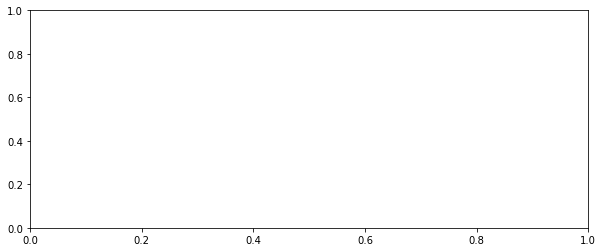

In [ ]:
# For a sample batch
inputs, targets = next(iter(dataloader))
inputs, targets = inputs.to(device), targets.to(device)

# Get predictions
model.eval()
with torch.no_grad():
    preds = model(inputs)

# Visualize
visualize_predictions(preds, targets, inputs, slice_range)


ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

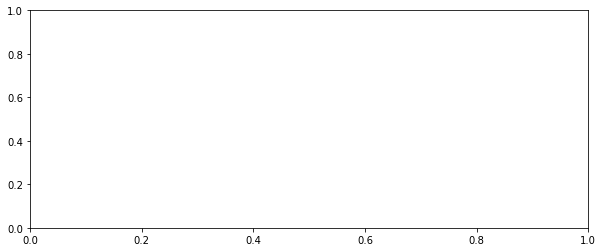

In [ ]:
# Unpack the inputs and targets
input_tensor, target_tensor = next(iter(dataloader))

# Move to device (CPU or GPU)
input_tensor = input_tensor.to(device)
target_tensor = target_tensor.to(device)

# Get model predictions
predictions = model(input_tensor)

# Visualize predictions
visualize_predictions(predictions, target_tensor, input_tensor, slice_range=(0, 21))  # or use 0–128 if more slices


In [ ]:
batch = next(iter(dataloader))
print(type(batch))
print(len(batch))
print(type(batch[0]), batch[0].shape)
print(type(batch[1]), batch[1].shape)


<class 'list'>
2
<class 'torch.Tensor'> torch.Size([1, 21, 1, 128, 128])
<class 'torch.Tensor'> torch.Size([1, 21, 2])


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def visualize_predictions(predictions, targets, inputs, slice_range=(0, 21), save_dir=None):
    # Assumes batch size = 1
    pred = predictions[0].cpu().numpy()  # shape (num_slices, 2)
    true = targets[0].cpu().numpy()

    # Flatten shifts (dY, dX) across slices
    pred_flat = pred[slice_range[0]:slice_range[1]]
    true_flat = true[slice_range[0]:slice_range[1]]

    slices = np.arange(slice_range[0], slice_range[1])

    # Create DataFrame
    df = pd.DataFrame({
        "Slice": slices,
        "True_dY": true_flat[:, 0],
        "True_dX": true_flat[:, 1],
        "Pred_dY": pred_flat[:, 0],
        "Pred_dX": pred_flat[:, 1],
    })
    print(df.head())
    print(df.dtypes)

    # 1. Line Plot: Predicted vs True shift
    plt.figure(figsize=(10, 4))

    plt.plot(df["Slice"].values, df["True_dY"].values, label="True dY", color="blue")
    plt.plot(df["Slice"].values, df["Pred_dY"].values, label="Pred dY", linestyle="--", color="blue")
    plt.plot(df["Slice"].values, df["True_dX"].values, label="True dX", color="red")
    plt.plot(df["Slice"].values, df["Pred_dX"].values, label="Pred dX", linestyle="--", color="red")

    plt.xlabel("Slice Index")
    plt.ylabel("Shift Value")
    plt.title("Predicted vs True Shifts")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot dY
#     plt.figure(figsize=(10, 4))
#     plt.plot(df["Slice"], df["True_dY"], label="True dY", marker='o')
#     plt.plot(df["Slice"], df["Pred_dY"], label="Pred dY", marker='x')
#     plt.title("dY: True vs Predicted")
#     plt.xlabel("Slice")
#     plt.ylabel("Shift")
#     plt.legend()
#     plt.grid(True)
#     if save_dir:
#         plt.savefig(f"{save_dir}/dy_plot.png")
#     plt.show()

#     # Plot dX
#     plt.figure(figsize=(10, 4))
#     plt.plot(df["Slice"], df["True_dX"], label="True dX", marker='o')
#     plt.plot(df["Slice"], df["Pred_dX"], label="Pred dX", marker='x')
#     plt.title("dX: True vs Predicted")
#     plt.xlabel("Slice")
#     plt.ylabel("Shift")
#     plt.legend()
#     plt.grid(True)
#     if save_dir:
#         plt.savefig(f"{save_dir}/dx_plot.png")
#     plt.show()


   Slice    True_dY   True_dX    Pred_dY   Pred_dX
0      0 -13.000000  1.000000  -8.798498 -0.351220
1      1 -14.500000  1.166667 -10.917867 -0.407026
2      2 -11.500000 -4.500000 -11.154698 -0.998196
3      3  -9.166667  1.666667  -9.618660  1.926599
4      4 -10.000000  6.500000  -9.540898  3.059592
Slice        int32
True_dY    float32
True_dX    float32
Pred_dY    float32
Pred_dX    float32
dtype: object


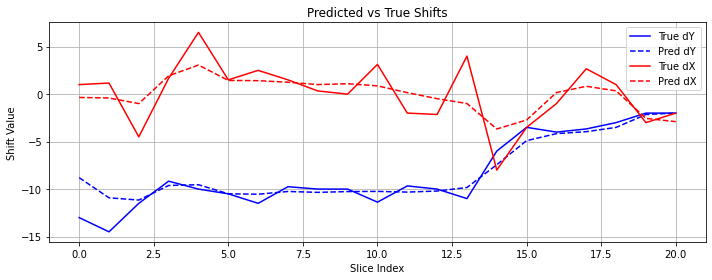

In [ ]:
model.eval()

# Get a batch
x, y = next(iter(dataloader))

# Move to device
x, y = x.to(device), y.to(device)

# Predict
with torch.no_grad():
    preds = model(x)

# Slice range (e.g., 0 to 21 for all slices)
slice_range = (0, x.shape[1])  # (0, 21) in your case

# Call the visualization function
visualize_predictions(preds, y, x, slice_range=slice_range)


In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def visualize_predictions(predictions, targets, inputs, slice_range=(0, 21), save_dir="eval_plots"):
    os.makedirs(save_dir, exist_ok=True)

    # Select single sample (first in batch)
    pred = predictions[0].detach().cpu().numpy()  # shape (num_slices, 2)
    true = targets[0].detach().cpu().numpy()      # shape (num_slices, 2)

    # Create DataFrame
    df = pd.DataFrame({
        "Slice": np.arange(slice_range[0], slice_range[1]),
        "True_dY": true[:, 0],
        "True_dX": true[:, 1],
        "Pred_dY": pred[:, 0],
        "Pred_dX": pred[:, 1]
    })

    # ----- 1. Line Plot -----
    plt.figure(figsize=(10, 4))
    plt.plot(df["Slice"].values, df["True_dY"].values, label="True dY", color="blue")
    plt.plot(df["Slice"].values, df["Pred_dY"].values, label="Pred dY", linestyle="--", color="blue")
    plt.plot(df["Slice"].values, df["True_dX"].values, label="True dX", color="red")
    plt.plot(df["Slice"].values, df["Pred_dX"].values, label="Pred dX", linestyle="--", color="red")
    plt.xlabel("Slice Index")
    plt.ylabel("Shift Value")
    plt.title("Predicted vs True Shifts")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "line_plot_shift_vs_slice.png"))
    plt.close()

    # ----- 2. Error Plot -----
    df["Error_dY"] = np.abs(df["True_dY"] - df["Pred_dY"])
    df["Error_dX"] = np.abs(df["True_dX"] - df["Pred_dX"])

    plt.figure(figsize=(10, 4))
    plt.plot(df["Slice"].values, df["Error_dY"].values, label="dY Error", color="blue")
    plt.plot(df["Slice"].values, df["Error_dX"].values, label="dX Error", color="red")
    plt.xlabel("Slice Index")
    plt.ylabel("Absolute Error")
    plt.title("Prediction Error per Slice")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "error_plot_per_slice.png"))
    plt.close()

    # ----- 3. Histogram of Errors -----
    plt.figure(figsize=(6, 4))
    plt.hist(df["Error_dY"], bins=10, alpha=0.7, label="dY Error", color="blue")
    plt.hist(df["Error_dX"], bins=10, alpha=0.7, label="dX Error", color="red")
    plt.xlabel("Absolute Error")
    plt.ylabel("Frequency")
    plt.title("Distribution of Prediction Errors")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "histogram_errors.png"))
    plt.close()

    # ----- 4. Scatter Plot: Pred vs True -----
    plt.figure(figsize=(6, 6))
    plt.scatter(df["True_dY"], df["Pred_dY"], alpha=0.7, label="dY", color="blue")
    plt.scatter(df["True_dX"], df["Pred_dX"], alpha=0.7, label="dX", color="red")
    plt.plot([df[["True_dY", "True_dX"]].min().min(), df[["True_dY", "True_dX"]].max().max()],
             [df[["True_dY", "True_dX"]].min().min(), df[["True_dY", "True_dX"]].max().max()],
             color='gray', linestyle='--')
    plt.xlabel("True Shift")
    plt.ylabel("Predicted Shift")
    plt.title("True vs Predicted Shifts (Scatter)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "scatter_true_vs_pred.png"))
    plt.close()

    # ----- 5. Print Mean Absolute Errors -----
    mae_dY = df["Error_dY"].mean()
    mae_dX = df["Error_dX"].mean()
    print(f"\nMAE (dY): {mae_dY:.4f}")
    print(f"MAE (dX): {mae_dX:.4f}")


In [ ]:
model.eval()
x, y = next(iter(dataloader))
x, y = x.to(device), y.to(device)
with torch.no_grad():
    preds = model(x)

visualize_predictions(preds, y, x, slice_range=(0, x.shape[1]), save_dir="eval_plots")



MAE (dY): 0.5462
MAE (dX): 1.0336


In [ ]:
model = CNNLSTMShiftPredictor()
print(model)


CNNLSTMShiftPredictor(
  (cnn): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (rnn): LSTM(32768, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)


In [ ]:
pip install torchsummary


Note: you may need to restart the kernel to use updated packages.


In [ ]:
# from torchsummary import summary

# model = CNNLSTMShiftPredictor().to(device)
# summary(model, input_size=(slice_len, 1, 128, 128))  # assuming you pass a sequence


In [ ]:
pip install torchviz


  Using cached graphviz-0.20.3-py3-none-any.whl.metadata (12 kB)
Using cached graphviz-0.20.3-py3-none-any.whl (47 kB)
Note: you may need to restart the kernel to use updated packages.


In [ ]:
seq_len = 21

In [ ]:
pip install torchinfo

Note: you may need to restart the kernel to use updated packages.
